# Week 9

**Welcome to Assignment 4 on Deep Learning for Computer Vision.**

This assignment is based on the content you learned in Week-9 of the course.


#### **Instructions**
1. Use Python 3.x to run this notebook
2. Write your code only in between the lines 'YOUR CODE STARTS HERE' and 'YOUR CODE ENDS HERE'.
you should not change anything else in the code cells, if you do, the answers you are supposed to get at the end of this assignment might be wrong.
3. Read documentation of each function carefully.
4. All the Best!

**Multi-Head Attention**

In this section, you will learn to implement the multi-head attention

In [ ]:
#imports: do not change them
import torch
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pickle
import os
import torch.nn as nn
from PIL import Image
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torchvision
import random
from tqdm import tqdm
from torch.utils.data import random_split
from torch.autograd import Variable
import cv2
import torchvision.utils as utils

## Please DONOT remove these lines.
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

In [ ]:
## Please DO NOT change these values.
#This is the config that will be used for implementing the Multi-head attention
config = {
    'QI_DIM': 64,     # Query Input Dim
    'VI_DIM': 64,     # Value Input Dim
    'KI_DIM': 64,     # Key Input Dim
    'QO_DIM': 32,     # Query Output Dim
    'VO_DIM': 32,     # Value Output Dim
    'OP_DIM': 32,     # Output Dim
    'NUM_HEADS': 8,
}

In [ ]:
#A class for implementing the Multi-head Attention
class MultiHeadAttention(nn.Module):

    def __init__(self, config):
        super(MultiHeadAttention, self).__init__()

        ### YOUR CODE STARTS HERE ###

        #set the op dimension, number of heads based on the value given in config
        self.op_dim = config['OP_DIM']
        self.n_heads = config['NUM_HEADS']

        #set the query dimension as QO_DIM from the config and value dimension as VO_DIM
        self.query_dim = config['QO_DIM']
        self.value_dim = config['VO_DIM']

        #set the respective dimensions
        #create linear layers with respective input and output dimensions
        self.QTrans = nn.Linear(config['QI_DIM'], config['QO_DIM'])
        self.KTrans = nn.Linear(config['KI_DIM'], config['QO_DIM'])
        self.VTrans = nn.Linear(config['VI_DIM'], config['VO_DIM'])
        self.OTrans = nn.Linear(config['VO_DIM'], config['OP_DIM'])

        ### YOUR CODE ENDS HERE ###

        self.scale = torch.sqrt(torch.FloatTensor([self.query_dim // self.n_heads]))


    def forward(self, q_inp, k_inp, v_inp, ret_atn=False):

        #making sure that shapes are similar across dim=0
        assert q_inp.shape[0] == k_inp.shape[0]

        #setting batch size
        batch_size = q_inp.shape[0]
        seq_length = q_inp.shape[1]

        ### YOUR CODE STARTS HERE ###
        #pass q_inp, k_inp, v_inp through the linear layers defined in the init function

        Q = self.QTrans(q_inp)
        K = self.KTrans(k_inp)
        V = self.VTrans(v_inp)

        #reshape the Q, K, V tensors to (batch_size, num_heads, -1, self.query_dim/num_heads)
        #hint: you can also do the same by the view() and permute() of pytorch


        # Q = Q.view(batch_size, self.n_heads, -1, self.query_dim//self.n_heads)
        # K = K.view(batch_size, self.n_heads, -1, self.query_dim//self.n_heads)
        # V = V.view(batch_size, self.n_heads, -1, self.query_dim//self.n_heads)

        Q = Q.view(batch_size, -1, self.n_heads, self.query_dim//self.n_heads).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.query_dim//self.n_heads).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.query_dim//self.n_heads).permute(0, 2, 1, 3)


        # define energy as matrix product of Q and K divided by self.scale value
        #hint: #use torch.matmul() for this and do not forget to reshape K vector as (batch_size, num_heads, self.query_dim/num_heads, -1)
               #this should be done in order to carry out the matrix multiplication
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

        #define attention as softmax of energy vector across the last dimension
        attention = torch.softmax(energy, dim=-1)

        ### YOUR CODE ENDS HERE ###

        #multiplying the attention with value tensor
        attended = torch.matmul(attention, V).permute(0, 2, 1, 3).contiguous()

        #passing the attended tensor through OTrans linear layer
        out = self.OTrans(attended.view(batch_size, seq_length, -1))

        if ret_atn:
            return out, attention

        else:
            return out

In [ ]:
## Please DONOT remove these lines.
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

q = torch.rand(4, 2, 64)
k = torch.rand(4, 2, 64)
v = torch.rand(4, 2, 64)
## Please DONOT remove these lines.

### YOUR CODE STARTS HERE ###

#initialise an instance of MultiHeadAttention class
d = MultiHeadAttention(config)

#pass q, k, v values through the instance and set ret_atn to True
x, y = d.forward(q, k, v, ret_atn=True)

#print the max value of the attention and report your answer
torch.max(y)

### YOUR CODE ENDS HERE ###


tensor(0.5590, grad_fn=<MaxBackward1>)

### Question 1:


Given a set of query, key, value vectors, calculate the attention value using multihead attention. Choose the closest option to the maximum value of the attention vector


a) 0.5590 \\
b) 0.7851 \\
c) 0.2312 \\
d) 0.9452

**Learning to pay attention**


For question 2, we will implement the paper "Learning to pay Attention", published at ICLR2018. The paper focuses on Trainable Soft Visual Attention in CNNs for image classification task. Follow the steps given in the upcoming code blocks to answer question 2.



In [ ]:
#defining a block that has conv->batchnorm->relu
class ConvBlock(nn.Module):
    def __init__(self, in_features, out_features, num_conv, pool=False):
        super(ConvBlock, self).__init__()
        features = [in_features] + [out_features for i in range(num_conv)]

        #appending all the operations in the list and then converting them to sequential set of operations
        layers = []
        for i in range(len(features)-1):
            layers.append(nn.Conv2d(in_channels=features[i], out_channels=features[i+1], kernel_size=3, padding=1, bias=True))
            layers.append(nn.BatchNorm2d(num_features=features[i+1], affine=True, track_running_stats=True))
            layers.append(nn.ReLU())
            if pool:
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2, padding=0))
        self.op = nn.Sequential(*layers)
    def forward(self, x):
        return self.op(x)

#defining a projector block which is nothing but a conv layer that is used to transform the channel dimension
class ProjectorBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super(ProjectorBlock, self).__init__()
        self.op = nn.Conv2d(in_channels=in_features, out_channels=out_features, kernel_size=1, padding=0, bias=False)
    def forward(self, inputs):
        return self.op(inputs)


#defining a linear attention block as mentioned in the paper
class LinearAttentionBlock(nn.Module):
    def __init__(self, in_features, normalize_attn=True):
        super(LinearAttentionBlock, self).__init__()

        ### YOUR CODE STARTS HERE ###
        #set self.normalize_attn as the normalize_attn argument
        self.normalize_attn = normalize_attn

        #define self.op as a conv layer with in_channels=in_features, out_channels=1, kernel_size=1, padding=0 and with bias=False
        self.op = nn.Conv2d(in_channels=in_features, out_channels=1, kernel_size=1, padding=0, bias=False)

        ### YOUR CODE ENDS HERE ###


    def forward(self, l, g):
        ### YOUR CODE STARTS HERE ###

        #set N, C, W, H using the size of the 'l' tensor
        #where N = number of batches, C = channels, H = height of the tensor, W = width of the tensor
        N, C, W, H = l.size()

        #add l and g and pass it through the self.op layer
        c = self.op(l + g) # batch_size x 1 x W x H

        #pass the output of the self.op layer through sigmoid activation function
        a = torch.sigmoid(c)

        #make the size of 'a' same as 'l'
        #hint: you can do this by the tensor.expand_as() method of PyTorch
        a = a.expand_as(l)

        #and then multiply 'a' and 'l' using torch.mul()
        g = torch.mul(a, l)

        ### YOUR CODE ENDS HERE ###

        #using adaptive avg pooling as the final operation
        g = F.adaptive_avg_pool2d(g, (1,1)).view(N,C)

        return c.view(N,1,W,H), g


In [ ]:
## Please DONOT remove/change these lines.
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)
att = LinearAttentionBlock(in_features=16, normalize_attn=True)

l = torch.rand(4, 16, 64, 64)
g = torch.rand(4, 16, 64, 64)
## Please DONOT remove/change these lines.


### YOUR CODE STARTS HERE ###
#pass the l and g vectors through the attention instance (defined in the lines above)
d, f = att(l, g)
#take the mean of all the elements present in the output 'f' vector and mark your answer for question 2
#hint: use torch.mean()
val = torch.mean(f)
### YOUR CODE ENDS HERE ###
print(val)

tensor(0.1692, grad_fn=<MeanBackward0>)


### Question 2:



What is the range of the mean value obtained?

a) 0.01 - 0.1 \\
b) 0.1 - 0.3  \\
c) 0.5 - 0.8  \\
d) 1 - 1.5



For the next question we will create image patches used in the ICLR 2021 paper,"An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale". In this case we consider only a single image in the batch. The shape of the batch is (batch_size, n_channel, height, width). We need to create patches of the image such that each patch is of size (patch_size,patch_size). After that we flatten these patches into a single vector to give the final image embedding which will be sent as an input to the transformer model.

In [ ]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

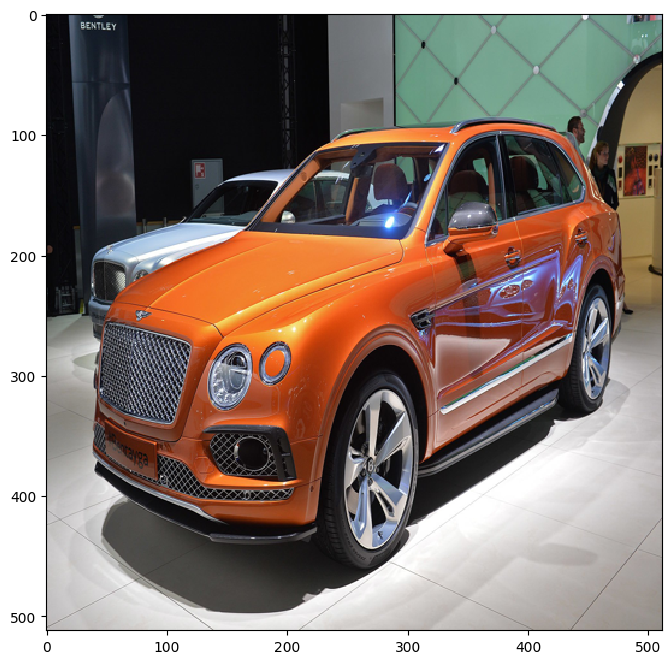

Image shape(1, 3, 512, 512)


In [ ]:
img = Image.open('car.png') #Set the path to the provided image - 'car.png'.
img = img.resize((512,512))
plt.imshow(img)
plt.show()
img = np.asarray(img)
img = np.expand_dims(img,axis=0)
img = np.transpose(img,(0,3,1,2))
print("Image shape"+str(img.shape))

Step 1: Create two new variables n_h and n_w that will store the number of patches across the height dimension and number of patches across the width dimension, respectively. (Hint: use the patch_size and the input height and width - number of patches in height dimension can be obtained by dividing the height by the patch_size.)

Step 2: Create patches by reshaping the input batch into "batch, (batch_size,c,n_h,patch_size,n_w,patch_size)" shape, and storing it in the variable 'patches'. (Hint: You need to split the input height dimension into n_h and patch_size, same for the input width)

Step 3: Rearrange the dimensions such that the final shape is (batch_size, c, n_h,n_w, patch_size,patch_size) and store it in the variable 'final_patch'.

Step 4: Flatten the final_patch into the shape (batch_size, n_hxn_w, cxpatch_sizexpatch_size) and store it in the variable flatten


In [ ]:
def img_patch(batch,patch_size):
  batch_size, c, h, w = batch.shape

  ## YOUR CODE STARTS HERE ##
  n_h, n_w = h//patch_size, w//patch_size

  patches = batch.reshape(batch_size, c, n_h, patch_size, n_w, patch_size)

  final_patch = patches.reshape(batch_size, c, n_h,n_w, patch_size,patch_size)

  flatten = final_patch.reshape(batch_size, n_h*n_w, c*patch_size*patch_size)
  ## YOUR CODE ENDS HERE ##
  return final_patch, flatten

In [ ]:
final_patch,flatten = img_patch(img,16)
print("Mean of final patch + flatten: "+str(np.average(final_patch)+np.average(flatten)))

Mean of final patch + flatten: 209.9131851196289


### Question 3:

The mean of the final_patch + flatten is?

a) 269.9 \\
b) 309.9 \\
c) 209.9 \\
d) 109.9

#Week 10



We will implement the ELBO loss used in VAE. The ELBO loss consists of two terms, reconstrustion loss and KL divergence term. The recontruction loss can be a MSE loss or Binary Cross Entropy Loss. The KL divergence can be be computed analytically as follows, provided that $q_\phi(z|x)$ is a $Z$-dimensional diagonal Gaussian with mean $\mu_{z|x}$ of shape $(Z,)$ and standard deviation $\sigma_{z|x}$ of shape $(Z,)$, and that $p(z)$ is a $Z$-dimensional Gaussian with zero mean and unit variance. Then we can write the KL divergence term as:

$D_{KL}(q_{\phi}(z|x), p(z))) = -\frac{1}{2} \sum_{j=1}^{J} (1 + log(\sigma_{z|x}^2)_{j} - (\mu_{z|x})^2_{j} - (\sigma_{z|x})^2_{j}$)

The KL divergence is also calculated using monte carlo approximation, where p and q can be any distribution.

We will first implement the ELBO loss using the analytical KL divergence and later implement the ELBO Loss using monte carlo approximation.

Step 1: Calculate the reconstruction loss using binary cross entropy loss between the variables x_hat and x, and store it in the variable recons_loss.

In [ ]:
import torch
from torch import nn

## Please DONOT change this lines.
torch.manual_seed(0)

x_hat = torch.randint(0,2,(1,1,32,32))
x = torch.randint(0,2,(1,1,32,32))

x_hat = x_hat.type(torch.float)
x = x.type(torch.float)

mu = torch.rand((1,40))
logvar = torch.rand(1,40)

In [ ]:
# Compute the reconstruction loss term, using Binary Cross Entropy (BCE) loss.
# The "BCE loss" has to be adapted to the "reconstruction loss" (Expectation) by:
# - Changing the reduction mode from 'mean' (default) to 'sum' (used in the Expectation).
# - The input to the BCE is 'x_hat' and the target is 'x'. This can be done because
# each element in the input is either 0 or 1.
# Note that the minus sign is handled by the BCE loss itself.

##YOUR CODE STARTS HERE##
recons_loss = nn.BCELoss(reduction='sum')(x_hat, x)
##YOUR CODE ENDS HERE##

Step 2: Calculate KL divergence using the analytic formula shown above and store it in the variable kldiv_term.

In [ ]:
def KL_analytical(mu, logvar):
  #- mu: Matrix representing estimated posterior mu (N, Z), with Z latent space dimension
  #- logvar: Matrix representing estimated variance in log-space (N, Z), with Z latent space dimension

  ##YOUR CODE STARTS HERE##
  kldiv_term = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  ##YOUR CODE ENDS HERE##
  return kldiv_term

In [ ]:
kl_analytic = KL_analytical(mu,logvar)

Calculate monte carlo estimation of KL divergence as follows.

Step 3: Define a normal distribution 'q' with mean mu and standard deviation std. Define another normal distribution 'p' with mean 0-vector in the shape of 'mu' and standard deviation 1-vector in the shape of 'std'.  (Hint: torch.distributions)

Step 4: Get the log probabilites from the distributions q and p for sample z and store it in variables log_qzx and log_pz, respectively.

Step 5: Subtract the log probabilities of q and p and store it in the variable kl.

Step 6: Find the sum of the variable kl across the last dimension and store it in the variable kl.

In [ ]:
def kl_mc(z, mu, std):
    # --------------------------
    # Monte carlo KL divergence
    # --------------------------

    ## YOUR CODE STARTS HERE
    # 1. define the first two probabilities (in this case Normal for both)
    q = torch.distributions.Normal(mu, std)
    p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))

    # 2. get the log probabilities
    log_qzx = q.log_prob(z)
    log_pz = p.log_prob(z)

    # kl
    kl = log_qzx - log_pz
    kl = torch.sum(kl, dim=-1)

    ##YOUR CODE ENDS HERE##

    return kl

In [ ]:
## Please DONOT change this lines.
torch.manual_seed(1)
std = torch.exp(logvar / 2)
q = torch.distributions.Normal(mu, std)
z = q.rsample(sample_shape=(1000,))

kl_approx = kl_mc(z, mu, std).mean()

print("Final modified loss: "+str((recons_loss/1000)+ (kl_approx - kl_analytic)*10))

Final modified loss: tensor(55.8064)


### Question 4:

What is the final modified loss printed from the above code output?

a) 62.4 \\
b) 55.8 \\
c) 82.6 \\
d) 28.2

**Adversarial Autoencoder(AAE)**

In the following problem we will implement an Adversarial Autoencoder(AAE) to map MNIST images into latent representations that follow a Gaussian distribution. Please refer to the lecture to understand the idea behind AAE.



In [ ]:
import math
import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import random
import os
import numpy as np
import torchvision.transforms as T
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(0)

In [ ]:
def show_images(images):
    images = torch.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(math.ceil(math.sqrt(images.shape[0])))
    sqrtimg = int(math.ceil(math.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

In [ ]:
dtype = torch.float

# set device

device = torch.device("cuda:0")

download MNIST if not exist


100%|██████████| 9912422/9912422 [00:00<00:00, 104628518.48it/s]


Extracting ./MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 93685764.75it/s]

Extracting ./MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 26680856.29it/s]


Extracting ./MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4607141.18it/s]


Extracting ./MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw



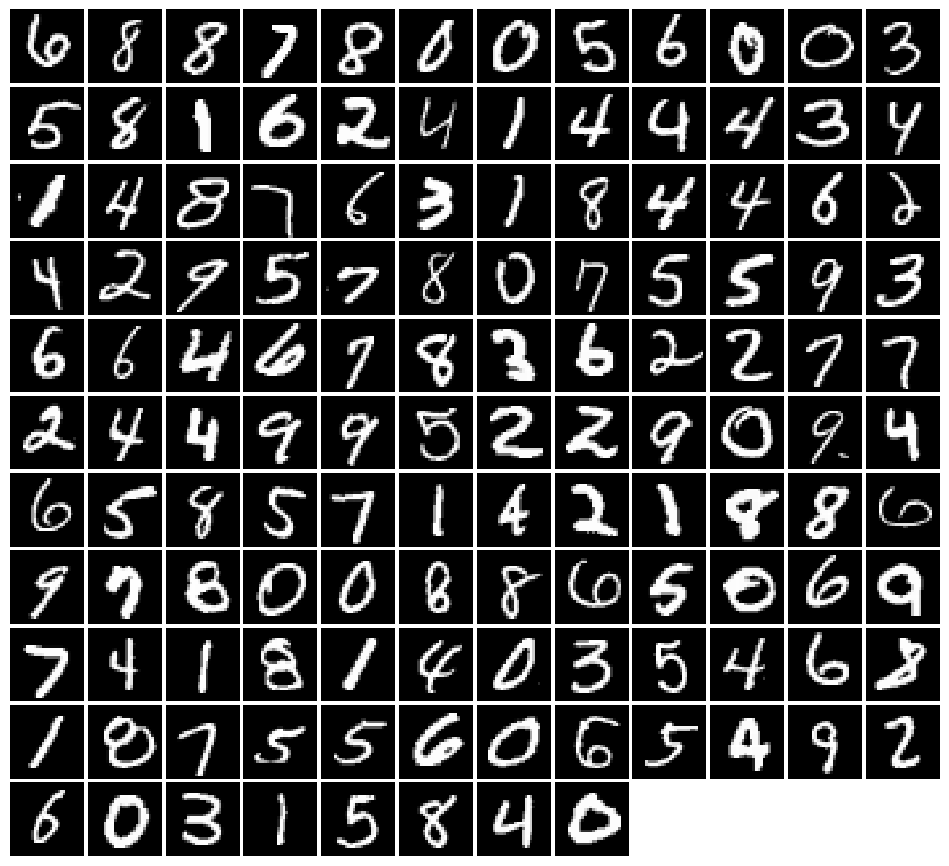

In [ ]:
# let us load the input images from the dataset and visualize some images!

batch_size = 128
NOISE_DIM = 96

print('download MNIST if not exist')

mnist_train = dset.MNIST('./MNIST_data', train=True, download=True,
                           transform=T.ToTensor())
loader_train = DataLoader(mnist_train, batch_size=batch_size,
                          shuffle=True, drop_last=True, num_workers=2)


imgs = next(iter(loader_train))[0].view(batch_size, 784)
show_images(imgs)

**Generating Random Noise**

The first step is to generate gaussian noise with mean 0 and variance 25 with shape `[batch_size, noise_dim]`. This noise will be used to draw samples of  vectors with the desired prior distribution to which we want to map our latent representations.

Hint: use `torch.randn`.

Implement `sample_gaussian_noise` below.

In [ ]:
def sample_gaussian_noise(batch_size, noise_dim, dtype=torch.float, device='cpu'):
  """
  Generate a PyTorch Tensor of uniform random noise.

  Input:
  - batch_size: Integer giving the batch size of noise to generate.
  - noise_dim: Integer giving the dimension of noise to generate.

  Output:
  - A PyTorch Tensor of shape (batch_size, noise_dim) containing gaussian noise with mean 0 and variance 25.
  """
  noise = None
  ## YOUR CODE STARTS HERE
  #Implement sample_noise.

  # The generated noise values (from gaussian distribution) must have mean 0
  # and variance 25.
  # However, "torch.randn" generates noise with variance 1.
  # For that, we must multiply the noise with appropiate constant which is the
  # square root of the desired variance

  noise = torch.randn((batch_size, noise_dim), device=device) * 5.0
  ## YOUR CODE ENDS HERE

  return noise

**Encoder, Decoder and Discriminator**

**The definitions of these functions are provided to you.**

They are explained below:

**Encoder**

The architecture is:
 * Flatten
 * Fully connected layer with input size 784 and output size 256
 * `LeakyReLU with alpha 0.01`
 * Fully connected layer with input size 256 and output size 256
 * `LeakyReLU with alpha 0.01`
 * Fully connected layer with input size 256 and output size is the `latent_size`.
  
The output of the discriminator is of shape `[batch_size, latent size]`, and contains the latent representations of each of the `batch_size` inputs.

**Decoder**

The architecture is:
 * Fully connected layer from `latent_size` to 1024
 * `ReLU`
 * Fully connected layer with input size 1024 and output size 1024
 * `ReLU`
 * Fully connected layer with input size 1024 and output size 784
 * `Sigmoid` (to clip the image to be in the range of [0,1])

 This outputs a tensor of shape of `[batch_size, 784]` that is the   reconstructed images in the batch.

**Discriminator**

The architecture is:
 * Fully connected layer from `latent_size` to 256
 * `LeakyReLU with alpha 0.1`
 * Fully connected layer with input size 256 and output size 256
 * `LeakyReLU with alpha 0.1`
 * Fully connected layer with input size 256 and output size 1

 This outputs a tensor of shape of `[batch_size, 1]` that is indication whether the latent noise input is coming for the real prior distribuition or not.

In [ ]:
LATENT_SIZE = 24 # default noise dimension

 ## YOUR CODE STARTS HERE

def encoder(latent_size=LATENT_SIZE):

  #Build and return a PyTorch nn.Sequential model implementing the architecture described above in the notebook.

  model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 256),  # 1st Fully-Connected layer.
    nn.LeakyReLU(0.01),
    nn.Linear(256, 256),  # 2nd Fully-Connected layer.
    nn.LeakyReLU(0.01),
    nn.Linear(256, latent_size)     # 3rd Fully-Connected layer.
  )

  return model


def decoder(latent_size=LATENT_SIZE):

  #Build and return a PyTorch nn.Sequential model implementing the described above architecture in the notebook.
  model = nn.Sequential(
    nn.Linear(latent_size, 1024),  # 1st Fully-Connected layer.
    nn.ReLU(),
    nn.Linear(1024, 1024),       # 2nd Fully-Connected layer.
    nn.ReLU(),
    nn.Linear(1024, 784),        # 3rd Fully-Connected layer.
    nn.Sigmoid()
  )

  return model


def discriminator(latent_size=LATENT_SIZE):
  ##############################################################################
  #TODO: Build and return a PyTorch nn.Sequential model implementing the
  # architecture in the notebook.
  ##############################################################################
  model = nn.Sequential(
    nn.Linear(latent_size, 256),  # 1st Fully-Connected layer.
    nn.LeakyReLU(0.1),
    nn.Linear(256, 256),       # 2nd Fully-Connected layer.
    nn.LeakyReLU(0.1),
    nn.Linear(256, 1)        # 3rd Fully-Connected layer.
  )

  return model

## YOUR CODE ENDS HERE


**Loss functions**

We will compute the generator and discriminator loss.

The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
We will be *minimizing* these losses. We have already implemented the functions to compute these losses. Please go trhough them carefully.



In [ ]:
def discriminator_loss(logits_real, logits_fake):
  """
  Computes the discriminator loss described above.

  Inputs:
  - logits_real: PyTorch Tensor of shape (N,) giving scores for the real data.
  - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.

  Returns:
  - loss: PyTorch Tensor containing (scalar) the loss for the discriminator.
  """
  loss = None

  # For the discriminator (D), the true target (y = 1) corresponds to "real" vectors.
  # Thus, for the scores of real vectors, the target is always 1 (a vector).
  real_labels = torch.ones_like(logits_real, device=device)
  # Compute the BCE for the scores of the real vectors.
  # Note that the BCE itself uses the Expectation formula (in addition, an average is
  # taken throughout the losses, not a sum [as requested in this assignment]).
  real_loss = F.binary_cross_entropy_with_logits(logits_real, real_labels)

  # For D, the false target (y = 0) corresponds to "fake" vectors.
  # Thus, for the scores of fake vectors, the target is always 0 (a vector).
  fake_labels = torch.zeros_like(logits_fake, device=device)
  # As for the real scores, compute the BCE loss for the fake vectors.
  fake_loss = F.binary_cross_entropy_with_logits(logits_fake, fake_labels)

  # Sum "real" and "fake" losses.
  # That is, BCE has already taken into account the "negated equation" form,
  # the "log" (in the Expectation) and the "mean" (insetead on the "sum").
  loss = real_loss + fake_loss

  return loss

def generator_loss(logits_fake):
  """
  Computes the generator loss described above.

  Inputs:
  - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.

  Returns:
  - loss: PyTorch Tensor containing the (scalar) loss for the generator.
  """
  loss = None

  # For the generator (G), the true target (y = 1) corresponds to "fake" vectors.
  # Thus, for the scores of fake vectors, the target is always 1 (a vector).
  fake_labels = torch.ones_like(logits_fake, device=device)
  # Compute the BCE for the scores of the fake vectors.
  fake_loss = F.binary_cross_entropy_with_logits(logits_fake, fake_labels)

  # The generator loss is "fake_loss".
  # That is, BCE has already taken into account the "negated equation" form,
  # the "log" (in the Expectation) and the "mean" (insetead on the "sum").
  loss = fake_loss

  return loss

**Training**

Complete the code below for the main training loop of the Adverserial Autoencoder.

In [ ]:
def run_aae(En, De, Ds, En_solver, De_solver, Ds_solver, Gn_solver, show_every=250,
              batch_size=128, latent_size=LATENT_SIZE, num_epochs=5):
  """
  Train an AAA!

  Inputs:
  - En, De, Ds: PyTorch models for the encoder, decoder and discriminator
  - En_solver, De_solver, Ds_solver, Gn_solver: torch.optim Optimizers to use for training the
    Enoder, Decoder, Discriminator and Generator(ie the encoder when it is used as a generator).
  - show_every: Show samples after every show_every iterations.
  - batch_size: Batch size to use for training.
  - latent_size: Dimension of the latent representation of the inputs.
  - num_epochs: Number of epochs over the training dataset to use for training.
  """
  iter_count = 0
  for epoch in range(num_epochs):
    for x, _ in loader_train:
      if len(x) != batch_size:
        continue

      ## YOUR CODE STARTS HERE

      En_solver.zero_grad()
      De_solver.zero_grad()
      real_data = x.view(-1, 784).to(device)

      #Compute the latent representations and the reconstructed images using
      # the encoder, deocder

      latent_sample = En(real_data)
      recon_data = De(latent_sample)

      #Compute the reconstruction loss between the real data and the
      # reconsructed data using binary cross entropy with reduction as 'sum'

      recon_loss = F.binary_cross_entropy(recon_data, real_data, reduction='sum')

      #Backpropagate the recon_loss and do an optimization step on the encoder
      # and decoder solvers

      recon_loss.backward()
      En_solver.step()
      De_solver.step()

      En.eval()

      # Generate random latent samples with desired gaussian distribution
      # using sample_gaussian_noise

      real_latent = sample_gaussian_noise(batch_size, latent_size, dtype=real_data.dtype,  device=real_data.device)

      #Generate fake latent samples from the real data using the encoder

      fake_latent = En(real_data)

      #Compute the logits corresponding to the real latent vectors and the fake
      # latent vectors using the discriminator

      logits_real_latent = Ds(real_latent)
      logits_fake_latent = Ds(fake_latent)

      #Compute the discriminator loss between the logits corresponding to the
      # real and fake latents using the discriminator loss function defined before

      ds_total_loss = discriminator_loss(logits_real_latent, logits_fake_latent)

      #Backpropagate the discriminator loss and do an optimization step on the
      # discriminator solver
      ds_total_loss.backward()
      Ds_solver.step()

      ## YOUR CODE ENDS HERE

      En.train()

      # Training the encoder based on the generator loss

      latent_sample_fake = En(real_data)
      gen_logits_fake = Ds(latent_sample_fake)
      g_loss = generator_loss(gen_logits_fake)

      g_loss.backward()
      Gn_solver.step()

      if (iter_count % show_every == 0):
        print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,ds_total_loss.item(),g_loss.item()))
        imgs_numpy = recon_data.data.cpu()#.numpy()
        show_images(imgs_numpy[0:16])
        plt.show()
        print()
      iter_count += 1
    if epoch == num_epochs - 1:
      show_images(imgs_numpy[0:16])


Now run the cell below to train the Adverserial Autoencoder!



Iter: 0, D: 1.339, G:0.6863


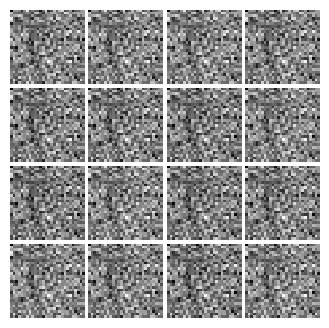


Iter: 250, D: 1.21, G:0.3951


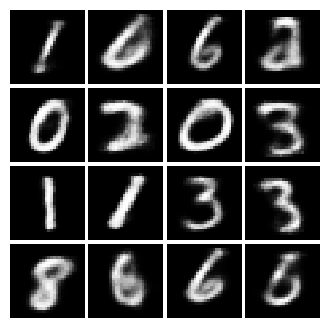


Iter: 500, D: 2.366, G:2.076


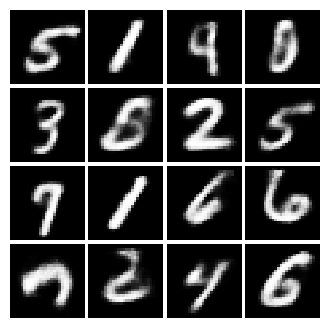


Iter: 750, D: 0.991, G:2.169


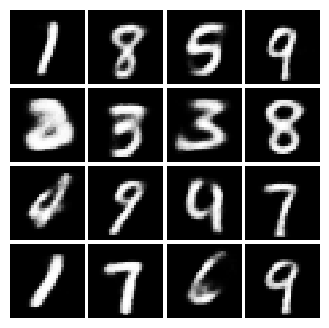


Iter: 1000, D: 5.319, G:0.2752


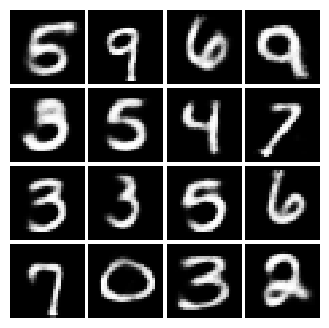


Iter: 1250, D: 2.211, G:5.381


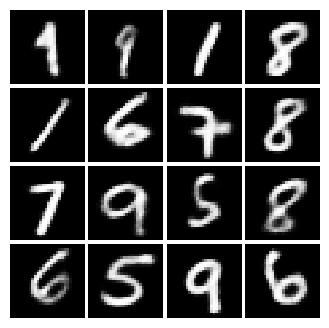


Iter: 1500, D: 15.11, G:1.714


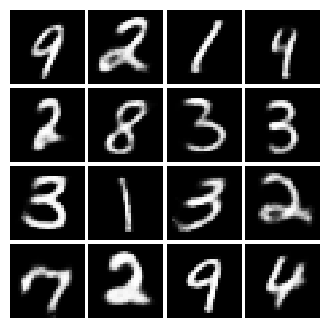


Iter: 1750, D: 14.0, G:1.501


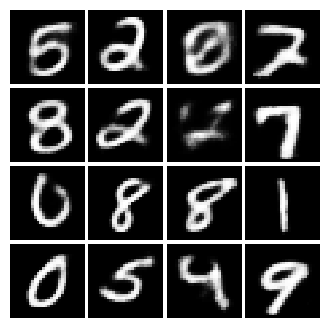


Iter: 2000, D: 10.45, G:2.188


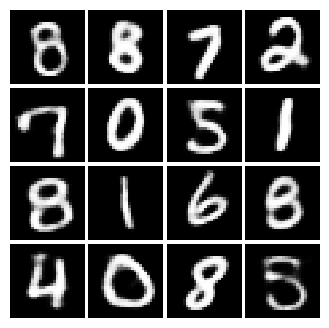


Iter: 2250, D: 2.6, G:46.87


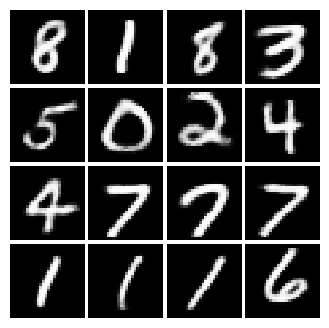

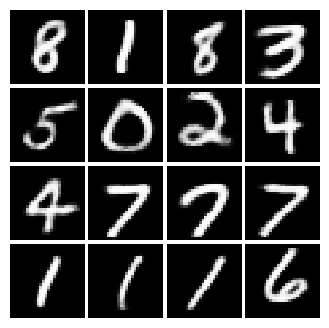

In [ ]:
# Leave this cell untouched

set_seed(0)

# Make the discriminator
En = encoder().to(device)

# Make the discriminator
De = decoder().to(device)

# Make the generator
Ds = discriminator().to(device)

# Use the function you wrote earlier to get optimizers for the Discriminator and the Generator
En_solver = optim.Adam(En.parameters(), lr=1e-3, betas=(0.5, 0.999))
De_solver = optim.Adam(De.parameters(), lr=1e-3, betas=(0.5, 0.999))
Ds_solver = optim.Adam(Ds.parameters(), lr=1e-3, betas=(0.5, 0.999))
Gn_solver = optim.Adam(En.parameters(), lr=1e-3, betas=(0.5, 0.999))

# Run it!
run_aae(En, De, Ds, En_solver, De_solver, Ds_solver, Gn_solver)

### Question 5:



What is the discriminator error after 2250 iterations displayed in the cell?


a) 3.6 \\
b) 4.6 \\
c) 1.6 \\
d) 2.6

### Question 6:


What is the generator error after 2250 iterations displayed in the cell? (Select the closest value)

a) 33.6 \\
b) 46.9 \\
c) 54.3 \\
d) 62.4

